# <center> CS439 Final Project: Predicting and Contextualizing Key Factors Influencing Student Academic Performance

### <center> Collaborators: Karthik Mudakalli (km1663), Daniel Tang (dt655), Joe Kim (jk1948)

In [89]:
import os
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

In [90]:
# Load Kaggle student performance data

spf_path = "StudentPerformanceFactors.csv"
spf = pd.read_csv(spf_path)

print("StudentPerformanceFactors shape:", spf.shape)
print(spf.head())

StudentPerformanceFactors shape: (6607, 20)
   Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   
3             29          89                  Low              Medium   
4             19          92               Medium              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   
3                        Yes            8               98           Medium   
4                        Yes            6               65           Medium   

  Internet_Access  Tutoring_Sessions Famil

In [91]:
#Load Rutgers course JSONs and departments

fall_path = "combined_courses_fall2025.json"
spring_path = "combined_courses_spring2026.json"
depts_path = "departments.json"

with open(fall_path, "r") as f:
    fall_raw = json.load(f)

with open(spring_path, "r") as f:
    spring_raw = json.load(f)

with open(depts_path, "r") as f:
    departments = json.load(f)

len(fall_raw["courseOfferings"]), len(spring_raw["courseOfferings"])


(2702, 3748)

This takes the messy Rutgers JSON and turns it into a clean table where each row is one course **section**. It pulls out basic info like subject, number, title, credits, and then looks at each meeting time to figure out things like how many days it meets, how long the class runs, earliest start time, latest end time, and the meeting mode. The result is a simple dataframe with one row per section that’s easy to work with.

In [92]:
# Helper to flatten course offerings into section level rows

def flatten_course_offerings(data):
    rows = []
    for course in data["courseOfferings"]:
        unit_code = course.get("offeringUnit", {}).get("code")
        subj = course.get("course", {}).get("subject")
        num = course.get("course", {}).get("number")
        core = course.get("coreCodes")
        title = course.get("title")
        full_title = course.get("fullTitle")
        credits_raw = course.get("credits")

        # Spring JSON sometimes does not have 'credits', treat as None
        credits = None
        if credits_raw not in (None, ""):
            try:
                credits = float(credits_raw)
            except Exception:
                credits = None

        sections = course.get("sections", [])
        for sec in sections:
            row = {
                "unit": unit_code,
                "subject": subj,
                "course_number": num,
                "coreCodes": core,
                "title": title,
                "fullTitle": full_title,
                "credits": credits,
            }
            # copy section fields except meetingTimes
            for k, v in sec.items():
                if k == "meetingTimes":
                    continue
                row[f"sec_{k}"] = v

            # schedule and resource features
            mtimes = sec.get("meetingTimes", [])
            days = set()
            modes = set()
            total_minutes = 0
            earliest_start = None
            latest_end = None

            for mt in mtimes:
                day = mt.get("meetingDay")
                if day:
                    days.add(day)

                sm = mt.get("startMinute")
                em = mt.get("endMinute")
                if sm and em and str(sm).isdigit() and str(em).isdigit():
                    sm_i = int(sm)
                    em_i = int(em)
                    if em_i > sm_i:
                        total_minutes += (em_i - sm_i)
                    earliest_start = sm_i if earliest_start is None else min(earliest_start, sm_i)
                    latest_end = em_i if latest_end is None else max(latest_end, em_i)

                mode_desc = mt.get("meetingModeDesc")
                if mode_desc:
                    modes.add(mode_desc)

            row["num_meeting_days"] = len(days)
            row["weekly_contact_minutes"] = total_minutes
            row["earliest_start_min"] = earliest_start
            row["latest_end_min"] = latest_end
            row["meeting_modes"] = ";".join(sorted(modes)) if modes else None

            rows.append(row)

    return pd.DataFrame(rows)

fall_sections = flatten_course_offerings(fall_raw)
spring_sections = flatten_course_offerings(spring_raw)

print("Fall sections:", fall_sections.shape)
print("Spring sections:", spring_sections.shape)
fall_sections.head()

Fall sections: (7695, 29)
Spring sections: (9758, 30)


,unit,subject,course_number,coreCodes,title,fullTitle,credits,sec_yearterm,sec_registrationIndex,sec_legendKey,...,sec_specialPermissionAdd,sec_comments,sec_instructors,sec_crossListedSections,sec_majors,num_meeting_days,weekly_contact_minutes,earliest_start_min,latest_end_min,meeting_modes
0,11,680,101,"Our Common Future (CCO), Natural Sciences (NS)",LIVING MICROBE WORLD,LIVING IN THE MICROBIAL WORLD ...,3.0,20259,15425,None,...,None,[],[{'name': 'KEDDIS'}],[],[],2,160,840.0,920.0,LEC
1,11,680,103,"Our Common Future (CCO), Natural Sciences (NS)",MICROBIAL PRODUCTS,MICROBIAL PRODUCTS IN A SUSTAINABLE GARDEN...,3.0,20259,15426,None,...,None,[],[{'name': 'ESQUILIN-LEBRON'}],[],[],1,180,840.0,1020.0,LEC
2,11,680,390,None,GENERAL MICROBIOLOGY,GENERAL MICROBIOLOGY,4.0,20259,15427,None,...,None,[ First Day Course Materials Charge. Go to: f...,"[{'name': 'ZYLSTRA, GERBEN'}, {'name': 'RAUSCH...",[],[],3,340,510.0,910.0,LAB;LEC
3,11,680,390,None,GENERAL MICROBIOLOGY,GENERAL MICROBIOLOGY,4.0,20259,15428,None,...,None,[ First Day Course Materials Charge. Go to: f...,"[{'name': 'ZYLSTRA, GERBEN'}, {'name': 'RAUSCH...",[],[],2,340,510.0,800.0,LAB;LEC
4,11,680,390,None,GENERAL MICROBIOLOGY,GENERAL MICROBIOLOGY,4.0,20259,15429,None,...,None,[ First Day Course Materials Charge. Go to: f...,"[{'name': 'ZYLSTRA, GERBEN'}, {'name': 'RAUSCH...",[],[],3,340,510.0,910.0,LAB;LEC


This merges all fall and spring sections and turns them into one row per **course**. It standardizes the course codes, groups all the sections of the same course together, and calculates averages like weekly contact hours and meeting days. It also grabs the earliest start and latest end times across all sections and combines all the meeting modes used. End result: a clean table where each row represents one unique course with summary info.

Want one row per course code across both terms

In [93]:
#Aggregate to course level features

course_sections = (
    pd.concat([fall_sections, spring_sections], ignore_index=True)
    .assign(
        unit=lambda d: d["unit"].astype(str).str.zfill(2),
        subject=lambda d: d["subject"].astype(str).str.zfill(3),
        course_number=lambda d: d["course_number"].astype(str).str.zfill(3),
    )
)

course_sections["course_code"] = (
    course_sections["unit"] + course_sections["subject"] + course_sections["course_number"]
)

course_features = (
    course_sections
    .groupby("course_code")
    .agg(
        unit=("unit", "first"),
        subject=("subject", "first"),
        course_number=("course_number", "first"),
        title=("title", "first"),
        credits=("credits", "first"),
        avg_weekly_contact_hours=("weekly_contact_minutes", lambda x: np.nanmean(x) / 60.0),
        avg_num_meeting_days=("num_meeting_days", "mean"),
        earliest_start_min=("earliest_start_min", "min"),
        latest_end_min=("latest_end_min", "max"),
        meeting_modes=("meeting_modes", lambda x: ";".join(sorted(set([m for m in x if isinstance(m, str)]))))
    )
    .reset_index()
)

print("Course features:", course_features.shape)
course_features.head()


Course features: (5106, 11)


,course_code,unit,subject,course_number,title,credits,avg_weekly_contact_hours,avg_num_meeting_days,earliest_start_min,latest_end_min,meeting_modes
0,01013111,01,013,111,BIBLE IN ARAMAIC,3.0,1.333333,1.0,840.0,920.0,LEC;ONLINE INSTRUCTION(INTERNET)
1,01013130,01,013,130,COMICS MIDEAST,3.0,2.666667,2.0,1170.0,1250.0,LEC
2,01013140,01,013,140,ELEMENTARY ARABIC I,4.0,2.666667,2.0,620.0,1140.0,LEC;ONLINE INSTRUCTION(INTERNET)
3,01013141,01,013,141,ELEMENTARY ARABIC II,4.0,2.666667,2.0,840.0,920.0,LEC;ONLINE INSTRUCTION(INTERNET)
4,01013143,01,013,143,ARABIC LAB 1,1.0,0.000000,0.0,NaN,NaN,ONLINE INSTRUCTION(INTERNET)


This adds extra labels to each course. First we map the subject code to a real department name. Then we use simple keyword checks to guess what broad discipline the course belongs to, like STEM, Business, Humanities, Social Science, or Other. It’s basically a quick way to group courses into bigger categories for plots or analysis.

In [94]:
# Add department name and discipline

course_features["department_name"] = course_features["subject"].map(departments)

def map_discipline(dept_name: str) -> str:
    if not isinstance(dept_name, str):
        return "Other"
    name = dept_name.upper()
    if any(k in name for k in ["ENGINEERING", "MATHEMATICS", "PHYSICS", "CHEMISTRY", "BIOLOGICAL", "BIOLOGY", "COMPUTER"]):
        return "STEM"
    if any(k in name for k in ["ECONOMICS", "PSYCHOLOGY", "SOCIOLOGY", "POLITICAL", "ANTHROPOLOGY"]):
        return "Social Science"
    if any(k in name for k in ["HISTORY", "LANGUAGE", "LITERATURE", "STUDIES", "PHILOSOPHY"]):
        return "Humanities"
    if any(k in name for k in ["BUSINESS", "ACCOUNTING", "FINANCE", "MANAGEMENT", "MARKETING"]):
        return "Business"
    return "Other"

course_features["discipline"] = course_features["department_name"].apply(map_discipline)

course_features.head()


,course_code,unit,subject,course_number,title,credits,avg_weekly_contact_hours,avg_num_meeting_days,earliest_start_min,latest_end_min,meeting_modes,department_name,discipline
0,01013111,01,013,111,BIBLE IN ARAMAIC,3.0,1.333333,1.0,840.0,920.0,LEC;ONLINE INSTRUCTION(INTERNET),"AFRICAN, MIDDLE EASTERN, AND SOUTH ASIAN LANGU...",Humanities
1,01013130,01,013,130,COMICS MIDEAST,3.0,2.666667,2.0,1170.0,1250.0,LEC,"AFRICAN, MIDDLE EASTERN, AND SOUTH ASIAN LANGU...",Humanities
2,01013140,01,013,140,ELEMENTARY ARABIC I,4.0,2.666667,2.0,620.0,1140.0,LEC;ONLINE INSTRUCTION(INTERNET),"AFRICAN, MIDDLE EASTERN, AND SOUTH ASIAN LANGU...",Humanities
3,01013141,01,013,141,ELEMENTARY ARABIC II,4.0,2.666667,2.0,840.0,920.0,LEC;ONLINE INSTRUCTION(INTERNET),"AFRICAN, MIDDLE EASTERN, AND SOUTH ASIAN LANGU...",Humanities
4,01013143,01,013,143,ARABIC LAB 1,1.0,0.000000,0.0,NaN,NaN,ONLINE INSTRUCTION(INTERNET),"AFRICAN, MIDDLE EASTERN, AND SOUTH ASIAN LANGU...",Humanities


Loads the degrees file into a dataframe so we can see all the majors and their requirement info. Reads CSV and shows first few rows.

In [95]:
# Load degrees

deg_path = "degrees.csv"
deg = pd.read_csv(deg_path)

print("Degrees shape:", deg.shape)
deg.head()

Degrees shape: (508, 5)


,ID,Name,Degree Code,Start Term,requirements
0,369,Degree Audit for Engineering Five - Year,NB,Fall 2003,NaN
1,6061,Major in Social Work,NB,NaN,"[{""id"": ""R1"", ""logic"": ""and"", ""title"": ""Prereq..."
2,2394,Degree Audit for Bioenvironmental Engineering ...,NB,Fall 2019,"[{""id"": ""R1"", ""logic"": ""and"", ""title"": ""First ..."
3,4542,Applied Sciences in Engineering - Packaging Op...,NB,Fall 2020,"[{""id"": ""R1"", ""logic"": ""and"", ""title"": ""First ..."
4,372,Undeclared School of Environmental and Biologi...,NB,Fall 2007,NaN


This code digs into each degree’s requirement JSON and pulls out the real Rutgers course codes. It filters out junk entries, keeps only valid 8-digit codes, and returns a clean list of unique courses required for that major. We add that list back into the degrees table so each degree has its own set of course codes we can use later.

In [96]:
#Parse requirements and extract course codes

def parse_course_code_str(code):
    """
    Return an 8 digit course code like '01119150' (unit 01, subject 119, number 150),
    ignore tokens like 'nb14_bioalt'.
    """
    if not isinstance(code, str):
        return None
    if len(code) < 8:
        return None
    prefix = code[:8]
    if not prefix.isdigit():
        return None
    return prefix

def extract_degree_course_codes(requirements_json_str):
    """
    Given the JSON string for one degree's requirements, return a sorted list of 8 digit course codes.
    """
    if pd.isna(requirements_json_str):
        return []
    try:
        blocks = json.loads(requirements_json_str)
    except Exception:
        return []
    codes = []
    for block in blocks:
        for req in block.get("requirements", []):
            for code in req.get("course_pool", []):
                parsed = parse_course_code_str(code)
                if parsed:
                    codes.append(parsed)
    return sorted(set(codes))

deg["course_codes"] = deg["requirements"].apply(extract_degree_course_codes)
deg[["Name", "course_codes"]].head(10)


,Name,course_codes
0,Degree Audit for Engineering Five - Year,[]
1,Major in Social Work,"[01119150, 01119154, 01119160, 01119182, 01830..."
2,Degree Audit for Bioenvironmental Engineering ...,"[01119103, 01160159, 01160160, 01160161, 01160..."
3,Applied Sciences in Engineering - Packaging Op...,"[01160159, 01160160, 01160171, 01160209, 01160..."
4,Undeclared School of Environmental and Biologi...,[]
5,"Degree Audit for Major in African, Middle East...","[01013201, 01013211, 01013221, 01013231, 01013..."
6,Degree Audit for Pre-med,[]
7,Degree Audit for Undeclared,[]
8,Biomedical Engineering (5 year),"[01119115, 01119117, 01160159, 01160160, 01160..."
9,Aerospace Engineering,"[01160159, 01160160, 01160171, 01355101, 01640..."


This takes each degree’s list of course codes and looks them up in the course features table. For every major, it gathers all the matched courses and calculates simple averages: how many courses mapped, the average credits, the average weekly contact hours, and the average number of meeting days. Basically, it turns a long list of required courses into a quick summary of how “heavy” the major is.

In [97]:
# Degree level summary from course level features

course_lookup = course_features.set_index("course_code")

def summarize_degree(code_list):
    rows = []
    for code in code_list:
        if code in course_lookup.index:
            rows.append(course_lookup.loc[code])
    if not rows:
        return pd.Series({
            "num_mapped_courses": 0,
            "avg_credits": np.nan,
            "avg_weekly_contact_hours": np.nan,
            "avg_num_meeting_days": np.nan,
        })
    df = pd.DataFrame(rows)
    return pd.Series({
        "num_mapped_courses": len(df),
        "avg_credits": df["credits"].mean(),
        "avg_weekly_contact_hours": df["avg_weekly_contact_hours"].mean(),
        "avg_num_meeting_days": df["avg_num_meeting_days"].mean(),
    })

deg_summary = deg.join(deg["course_codes"].apply(summarize_degree))
deg_summary[["Name", "num_mapped_courses", "avg_credits", "avg_weekly_contact_hours", "avg_num_meeting_days"]].head(10)


,Name,num_mapped_courses,avg_credits,avg_weekly_contact_hours,avg_num_meeting_days
0,Degree Audit for Engineering Five - Year,0.0,NaN,NaN,NaN
1,Major in Social Work,25.0,3.400000,1.739013,0.919346
2,Degree Audit for Bioenvironmental Engineering ...,50.0,2.780000,2.915657,1.995677
3,Applied Sciences in Engineering - Packaging Op...,41.0,2.951220,2.943991,1.826664
4,Undeclared School of Environmental and Biologi...,0.0,NaN,NaN,NaN
5,"Degree Audit for Major in African, Middle East...",3.0,3.000000,2.666667,2.000000
6,Degree Audit for Pre-med,0.0,NaN,NaN,NaN
7,Degree Audit for Undeclared,0.0,NaN,NaN,NaN
8,Biomedical Engineering (5 year),32.0,2.593750,2.923252,1.968253
9,Aerospace Engineering,41.0,2.853659,2.886441,2.022962


At this pt we can see see which degrees have many mapped courses and higher avg workload

This sets up the data for predicting exam scores. We split the Kaggle dataset into features (X) and the target (y), separate the numeric and categorical columns, and build a preprocessing step that keeps numeric features as-is and one-hot encodes all categorical ones. Then we do an 80/20 train-test split so our models can train on one part of the data


In [98]:
#Prepare data for modeling

target_col = "Exam_Score"
X = spf.drop(columns=[target_col])
y = spf[target_col]

# Identify numeric vs categorical columns
numeric_cols = [
    "Hours_Studied",
    "Attendance",
    "Sleep_Hours",
    "Previous_Scores",
    "Tutoring_Sessions",
    "Physical_Activity",
]

categorical_cols = [c for c in X.columns if c not in numeric_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

len(X_train), len(X_test)

(5285, 1322)

Linear Regression and Random Forest models

Builds a simple linear regression model wrapped in a pipeline so the preprocessing happens automatically. It trains the model on the training data, makes predictions on the test set, and then prints out how well it did using MAE and R². It’s basically our baseline model to see how well a straightforward approach works.

In [99]:
# Linear regression model

lin_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LinearRegression())
    ]
)

lin_model.fit(X_train, y_train)
lin_preds = lin_model.predict(X_test)

lin_mae = mean_absolute_error(y_test, lin_preds)
lin_r2 = r2_score(y_test, lin_preds)

print("LinearRegression MAE:", lin_mae)
print("LinearRegression R^2:", lin_r2)


LinearRegression MAE: 0.44994950022707
LinearRegression R^2: 0.7699282240123634


These numbers show how well the linear regression performed. The MAE of about 0.45 means the model’s predictions are usually off by less than half a point, which is pretty solid. The R^2 of about 0.77 means it explains around 77 percent of the variation in exam scores. For such a simple model, this is very strong performance.

Random Forest Regression Model

This trains a random forest model using the same preprocessing as before but with 200 trees. After fitting it on the training data, we predict on the test set and calculate MAE and R² again. This lets us directly compare how a more complex, nonlinear model performs compared to simple linear regression.

In [100]:
# Random Forest regression model

rf_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1,
        ))
    ]
)

rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)

print("RandomForest MAE:", rf_mae)
print("RandomForest R^2:", rf_r2)


RandomForest MAE: 1.083521180030257
RandomForest R^2: 0.6687538289195438


These results show the random forest didn’t perform as well as the linear model. The MAE is higher (about 1.08), meaning its predictions are off by more than a full point on average, and the R^2 is lower (about 0.67), meaning it explains less of the score variation. Even though random forests are usually strong, the relationships in this dataset are mostly linear, so the simpler model actually wins here.

### Model Comparison Plot (Clean)

Plots Linear Regression and Random Forest for easy comparison

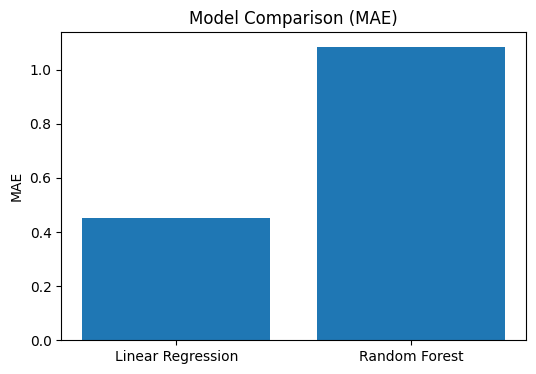

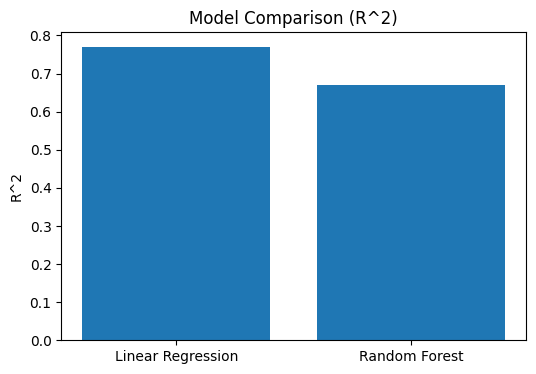

In [101]:
models = ["Linear Regression", "Random Forest"]
maes = [lin_mae, rf_mae]
r2s = [lin_r2, rf_r2]

plt.figure(figsize=(6,4))
plt.bar(models, maes)
plt.ylabel("MAE")
plt.title("Model Comparison (MAE)")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(models, r2s)
plt.ylabel("R^2")
plt.title("Model Comparison (R^2)")
plt.show()

Feature importance from Random Forest

This section grabs the actual feature names that the random forest sees after one-hot encoding, then pulls out the forest’s feature importances. It builds a table showing which features mattered most to the model. Sorting them makes it easy to see the top predictors in the dataset.

In [102]:
# Fit a preprocessing only transformer to recover feature names
ohe = OneHotEncoder(handle_unknown="ignore")
ohe.fit(X[categorical_cols])

cat_feature_names = list(ohe.get_feature_names_out(categorical_cols))
all_feature_names = numeric_cols + cat_feature_names

# Extract the underlying RF model
rf_inner = rf_model.named_steps["model"]

importances = rf_inner.feature_importances_
importance_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances,
}).sort_values("importance", ascending=False)

importance_df.head(20)


,feature,importance
1,Attendance,0.374569
0,Hours_Studied,0.239534
3,Previous_Scores,0.084366
4,Tutoring_Sessions,0.033088
5,Physical_Activity,0.024895
2,Sleep_Hours,0.024207
9,Access_to_Resources_High,0.018669
6,Parental_Involvement_High,0.018005
7,Parental_Involvement_Low,0.013118
10,Access_to_Resources_Low,0.011244


Above is a ranked list of most influential features on predicted exam score

These importances make the model’s behavior pretty clear. The forest is leaning almost entirely on two things: Attendance and Hours_Studied. Together they make up more than half the total importance, which means the model is mostly saying, “Did you show up? And did you actually study?” Everything else is secondary.

The next group of features

Previous_Scores, Tutoring_Sessions, Physical_Activity, Sleep_Hours

have noticeably smaller weights. This suggests the model sees them as helpful but not game changing. They tweak the prediction rather than drive it.

The categorical features being sprinkled throughout the ranking is interesting. Things like resource access, parental involvement, income level, and motivation do matter, but they don’t shift outcomes nearly as strongly as the direct behavioral variables. That implies structural or background factors influence performance, but the biggest gains come from consistent study habits and attendance.

Overall, the results tell us the exam score in this dataset is dominated by routine behavior patterns rather than personal background or environment. The random forest is basically learning a simple rule: steady effort and consistent attendance predict higher performance, while everything else adds small adjustments.

## Simulation: connect Rutgers degree features to Kaggle predictors

### Heuristic mapping function

This function takes a degree’s average workload and turns it into a fake “student profile” in the same format as the Kaggle dataset. It uses simple formulas to guess study hours and attendance based on how heavy the major is. Everything else (like motivation, income, sleep, etc.) is filled in with default middle-of-the-road values. The idea isn’t to be realistic, but to create a consistent way to plug majors into our exam score model and see how they might perform under similar conditions.

In [103]:
# Map a degree row to a Kaggle style feature dict

def make_kaggle_features_from_degree(degree_row,
                                     hours_base=8.0,
                                     hours_scale=2.5,
                                     attendance_base=92.0,
                                     attendance_penalty_per_day=2.5):
    """
    Given a degree row from deg_summary, estimate values for the Kaggle features.
    This is a heuristic. You can tune constants and mapping logic.
    """
    workload_hours = degree_row["avg_weekly_contact_hours"]
    days = degree_row["avg_num_meeting_days"]

    if np.isnan(workload_hours):
        workload_hours = 0.0
    if np.isnan(days):
        days = 0.0

    # Approx study hours
    hours_studied = hours_base + hours_scale * workload_hours
    # Approx attendance
    attendance = attendance_base - attendance_penalty_per_day * days

    # Clip to realistic ranges
    hours_studied = float(np.clip(hours_studied, 0, 50))
    attendance = float(np.clip(attendance, 50, 100))

    # Other variables treated as scenario parameters
    features = {
        "Hours_Studied": hours_studied,
        "Attendance": attendance,
        "Sleep_Hours": 7.0,
        "Previous_Scores": 75.0,
        "Motivation_Level": "Medium",
        "Parental_Involvement": "Medium",
        "Access_to_Resources": "Medium",
        "Extracurricular_Activities": "Yes",
        "Internet_Access": "Yes",
        "Tutoring_Sessions": 1,
        "Family_Income": "Medium",
        "Teacher_Quality": "Medium",
        "School_Type": "Public",
        "Peer_Influence": "Neutral",
        "Physical_Activity": 3,
        "Learning_Disabilities": "No",
        "Parental_Education_Level": "College",
        "Distance_from_Home": "Moderate",
        "Gender": "Male",
    }
    return features

### Predict exam scores for each degree

This takes the fake “student profile” we built for each major and runs it through the random forest model to get a predicted exam score. It basically treats every degree as if it produces a typical student with workload-based study hours and attendance, then asks the model, “What score would that kind of student get?” The result is a new column where every major has an estimated exam score based on its overall workload.

In [104]:
def predict_degree_score(model, degree_row):
    feat = make_kaggle_features_from_degree(degree_row)
    X_sim = pd.DataFrame([feat])
    return float(model.predict(X_sim)[0])

deg_summary["predicted_exam_score_rf"] = deg_summary.apply(
    lambda row: predict_degree_score(rf_model, row),
    axis=1
)

deg_summary[["Name", "num_mapped_courses", "avg_weekly_contact_hours", "avg_num_meeting_days", "predicted_exam_score_rf"]].head(10)

,Name,num_mapped_courses,avg_weekly_contact_hours,avg_num_meeting_days,predicted_exam_score_rf
0,Degree Audit for Engineering Five - Year,0.0,NaN,NaN,66.240
1,Major in Social Work,25.0,1.739013,0.919346,66.630
2,Degree Audit for Bioenvironmental Engineering ...,50.0,2.915657,1.995677,66.415
3,Applied Sciences in Engineering - Packaging Op...,41.0,2.943991,1.826664,66.415
4,Undeclared School of Environmental and Biologi...,0.0,NaN,NaN,66.240
5,"Degree Audit for Major in African, Middle East...",3.0,2.666667,2.000000,66.390
6,Degree Audit for Pre-med,0.0,NaN,NaN,66.240
7,Degree Audit for Undeclared,0.0,NaN,NaN,66.240
8,Biomedical Engineering (5 year),32.0,2.923252,1.968253,66.415
9,Aerospace Engineering,41.0,2.886441,2.022962,66.395


These results show the model’s predicted exam scores for each major after plugging in the workload-based “fake student” profiles. The scores barely move, mostly staying around 66.2 to 66.6. That tells us two things: first, the mapping from workload to study hours and attendance doesn’t create big differences between majors. Second, the random forest itself isn’t very sensitive to small shifts in these workload-driven inputs. So even though some majors clearly have heavier course loads, the model’s prediction barely changes, which suggests the simulation is dominated by the default values we set rather than true structural differences across degrees.

### Compare degrees by predicted score

Top 15 degrees by predicted exam score under baseline scenario

In [105]:
top_degrees = (
    deg_summary
    .dropna(subset=["predicted_exam_score_rf"])
    .sort_values("predicted_exam_score_rf", ascending=False)
    .head(15)
)[["Name", "num_mapped_courses", "avg_weekly_contact_hours", "predicted_exam_score_rf"]]

top_degrees


,Name,num_mapped_courses,avg_weekly_contact_hours,predicted_exam_score_rf
245,Minor in Animation,3.0,5.111111,68.730
328,Minor in Cinema Studies,2.0,5.833333,68.670
362,Master of Education (GSE) - Physical Science a...,8.0,3.824405,68.595
27,Master of Education (GSE) - Bio Sci Education ...,8.0,3.824405,68.595
39,Master of Education (GSE) - Biological Science...,8.0,3.824405,68.595
211,Major in Visual Arts (for the B.F.A.),65.0,4.954511,68.535
125,Minor in Entomology,1.0,5.666667,68.390
329,Minor in Art,6.0,4.314815,68.165
458,Degree Audit for Major in Filmmaking (for the ...,20.0,4.410537,68.160
390,Major in Cinema Studies,8.0,5.333333,68.075


These are majors w **highest predicted exam scores** under the simulation. What stands out is that these degrees all have **pretty high weekly contact hours**, usually around 4 to 6 hrs. Because your mapping converts workload into more study hours, the model responds by bumping the predicted score up.

But key point is differences are still pretty small. "Top" majors only end up around 67 to 69, which is just a couple points above the earlier examples. This tells us the model isn’t reacting dramatically to workload changes. Most of the predicted variation is coming from the hours studied formula we wrote, not from any deep structure in the Kaggle model.

So while heavier-workload programs show slightly higher predicted scores, the takeaway is that the simulation is pretty coarse. The model doesn’t truly know anything about majors and is just responding to the workload to study hrs conversion. The ranking mostly reflects which degrees have more class time and not meaningful differences in academic difficulty.

Bottom 15 degrees:

In [106]:
bottom_degrees = (
    deg_summary
    .dropna(subset=["predicted_exam_score_rf"])
    .sort_values("predicted_exam_score_rf", ascending=True)
    .head(15)
)[["Name", "num_mapped_courses", "avg_weekly_contact_hours", "predicted_exam_score_rf"]]

bottom_degrees


,Name,num_mapped_courses,avg_weekly_contact_hours,predicted_exam_score_rf
132,"Minor in Environmental Policy, Institutions, a...",1.0,1.650000,65.875
309,Major in Jewish Studies - Advanced Language Op...,7.0,2.904762,65.945
473,Minor in Hungarian,1.0,4.166667,66.205
396,Minor in International and Global Studies,1.0,1.333333,66.220
124,Minor in Military Science - Non-commissioning ...,12.0,1.250000,66.220
475,Major in Portuguese,4.0,1.333333,66.220
300,Minor in Health Equity,1.0,1.333333,66.220
420,Minor in Asian Studies,2.0,1.333333,66.220
138,Honors Program -SEBS,1.0,1.333333,66.220
277,Minor in Urban Studies,1.0,1.333333,66.220


These are the majors with the **lowest predicted scores** in the simulation. They mostly cluster around light workloads and are often just one or two mapped courses with very low weekly contact hours. Since the sim assumes more workload = more study hours: low workload majors end up with slightly lower predicted exam scores.

But the key pattern is how small the differences are. Even bottom majors are only about one to two points below the average predicted score. This means the model is not truly distinguishing between degrees and is mostly responding to how many contact hours they happened to have in the dataset.

So lightworkload majors get slightly lower simulated scores, but the variation is tiny. The simulation doesn’t reflect real academic difficulty and just mirrors the workload-based formula we defined.

### Correlation between workload and predicted score

In [107]:
corr = deg_summary[["avg_weekly_contact_hours", "predicted_exam_score_rf"]].corr()
corr

,avg_weekly_contact_hours,predicted_exam_score_rf
avg_weekly_contact_hours,1.000000,0.695318
predicted_exam_score_rf,0.695318,1.000000


The correlation is about 0.69. It looks strong at first. It happens mostly because our simulation increases study hours when workload goes up. This creates the pattern. The model is not finding something deep about majors. It is mostly following the rule we built into the simulation.

### Simple what if for one major

Example: take a specific major and vary motivation and teacher quality.

In [108]:
def simulate_scenarios_for_degree(degree_name, motivation_levels=None, teacher_qualities=None):
    if motivation_levels is None:
        motivation_levels = ["Low", "Medium", "High"]
    if teacher_qualities is None:
        teacher_qualities = ["Low", "Medium", "High"]

    rows = []
    subset = deg_summary[deg_summary["Name"].str.contains(degree_name, case=False, na=False)]
    if subset.empty:
        print("No matching degree for:", degree_name)
        return pd.DataFrame()

    degree_row = subset.iloc[0]

    for mot in motivation_levels:
        for tq in teacher_qualities:
            feat = make_kaggle_features_from_degree(degree_row)
            feat["Motivation_Level"] = mot
            feat["Teacher_Quality"] = tq
            X_sim = pd.DataFrame([feat])
            pred = float(rf_model.predict(X_sim)[0])
            rows.append({
                "Degree": degree_row["Name"],
                "Motivation_Level": mot,
                "Teacher_Quality": tq,
                "Predicted_Exam_Score": pred,
            })

    return pd.DataFrame(rows)

cs_scenarios = simulate_scenarios_for_degree("Computer Science")
cs_scenarios

,Degree,Motivation_Level,Teacher_Quality,Predicted_Exam_Score
0,Major in Data Science - Computer Science Optio...,Low,Low,66.900
1,Major in Data Science - Computer Science Optio...,Low,Medium,66.975
2,Major in Data Science - Computer Science Optio...,Low,High,67.365
3,Major in Data Science - Computer Science Optio...,Medium,Low,66.940
4,Major in Data Science - Computer Science Optio...,Medium,Medium,67.015
5,Major in Data Science - Computer Science Optio...,Medium,High,67.405
6,Major in Data Science - Computer Science Optio...,High,Low,67.100
7,Major in Data Science - Computer Science Optio...,High,Medium,67.205
8,Major in Data Science - Computer Science Optio...,High,High,67.695


These scenario results are simple. Motivation goes up and the score rises a little. Teacher quality goes up and the score rises a little. The changes are small. The pattern is smooth. The model is not reacting strongly to these inputs. It mostly treats them as small adjustments. This shows the simulation is stable. It also shows the model is not very sensitive to these specific factors.

### Deep Learning

Course Feature matrix

In [132]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd

auto_features = [
    "credits",
    "avg_weekly_contact_hours",
    "avg_num_meeting_days",
    "earliest_start_min",
    "latest_end_min",
]

cf = course_features.dropna(subset=auto_features).reset_index(drop=True)
X = cf[auto_features].values.astype(np.float32)


Picks a small set of course features for the autoencoder. Drops any courses that do not have valid values. Converts remaining data into a clean numeric array. This gets dataset ready for deep learning model.

In [133]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

X_tensor = torch.tensor(X_scaled)

Scales all course feature values. Standardizes each column to a common range. Creates a tensor for training. Prepares data for the autoencoder.

In [134]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)  # latent layer
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z

input_dim = X_tensor.shape[1]
model_shallow = Autoencoder(input_dim)


Defines a small autoencoder model. Builds an encoder that shrinks data down to two values. Builds a decoder that expands those two values back to the original size. Creates a full model ready for training.

In [135]:
#train autoencoder
criterion = nn.MSELoss()
optimizer = optim.Adam(model_shallow.parameters(), lr=0.001)

X_train = X_tensor

epochs = 50
batch_size = 32

print("Training shallow autoencoder...")
for ep in range(epochs):
    perm = torch.randperm(len(X_train))
    total_loss = 0.0 

    for i in range(0, len(X_train), batch_size):
        idx = perm[i:i+batch_size]
        batch = X_train[idx]

        optimizer.zero_grad()
        recon, _ = model_shallow(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    if ep % 10 == 0:
        print(f"Epoch {ep}, Loss {total_loss:.4f}")

Training shallow autoencoder...
Epoch 0, Loss 101.0927
Epoch 10, Loss 23.0887
Epoch 20, Loss 18.5079
Epoch 30, Loss 15.8773
Epoch 40, Loss 14.3081


Trains the autoencoder for fifty epochs. Shuffles data each round. Feeds small batches through the model. Computes reconstruction loss. Updates weights with Adam. Slowly teaches model to compress and rebuild course features.

In [136]:
#2d latent embeddings
model_shallow.eval()
with torch.no_grad():
    _, Z_shallow_tensor = model_shallow(X_tensor)

Z_shallow = Z_shallow_tensor.numpy()
Z_shallow.shape  # (num_courses, 2)

(3624, 2)

Runs the trained autoencoder on all courses. Produces two dimensional latent points. Converts results to a numpy array. Creates a compact embedding for each course.

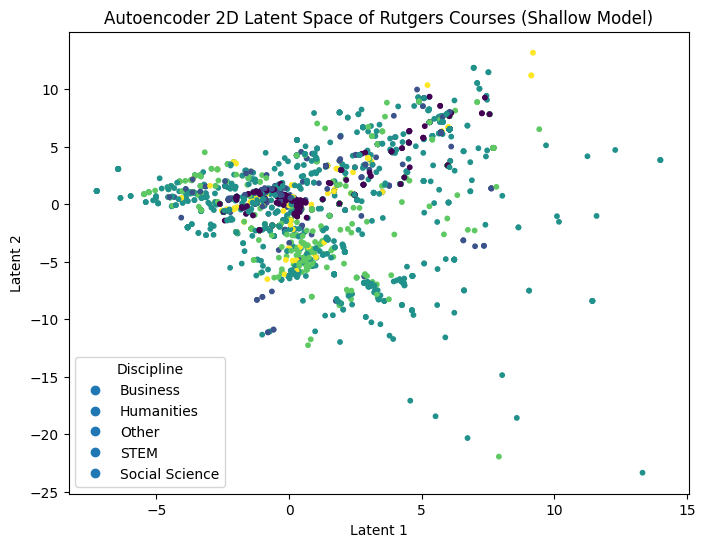

In [138]:
#visualize
import matplotlib.pyplot as plt

disciplines = cf["discipline"].values
unique_disc = sorted(set(disciplines))
color_map = {d: i for i, d in enumerate(unique_disc)}
colors = [color_map[d] for d in disciplines]

plt.figure(figsize=(8,6))
plt.scatter(Z_shallow[:,0], Z_shallow[:,1], c=colors, s=10)
plt.title("Autoencoder 2D Latent Space of Rutgers Courses (Shallow Model)")
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")

handles = [plt.Line2D([], [], marker="o", linestyle="", label=d, markersize=6) for d in unique_disc]
plt.legend(handles=handles, title="Discipline")

plt.show()

The autoencoder learns patterns from five course features. These include credits, weekly contact hours, meeting days, earliest start time, and latest end time. The model squeezes each course into two numbers. These numbers form a map of course structure.

### What the autoencoder learns

The model has no knowledge of departments. The model only sees workload patterns. Any shapes in the plot come from how courses meet and how long they run. The map shows structure in the data. The model groups courses with similar schedules.

Training loss drops fast. It starts very high and falls to a stable range by epoch 40. This shows the model learns a basic compression pattern but does not reach the deeper model’s reconstruction quality. The loss curve flattens early. This means the shallow network reaches its capacity quickly.

The latent map shows a loose structure. Courses form a central mass with long stretched branches. The shape is noisier than the deep model. Points spread farther on both axes. This happens bc the model has fewer layers to smooth variations in the course features.

The shallow embedding still captures broad groups. Courses with similar workloads drift toward the same areas. Courses with unusual time patterns drift farther out. The structure is present but softer. Boundaries between clusters are hard to see. Disciplines overlap heavily.

Overall the shallow model learns coarse structure only. It picks up general workload patterns but fails to separate nuanced scheduling types. It also produces more scattered outliers since the encoder is simple.

This gives a baseline representation. The deeper model improves on nearly every aspect.

### A More Comprehensive Model...

Epoch 0, Loss 98.3771
Epoch 50, Loss 15.4305
Epoch 100, Loss 12.9132
Epoch 150, Loss 10.9390
Epoch 200, Loss 10.5499
Epoch 250, Loss 9.6961
Epoch 300, Loss 9.8193
Epoch 350, Loss 9.1190
Epoch 400, Loss 8.8977
Epoch 450, Loss 8.7176


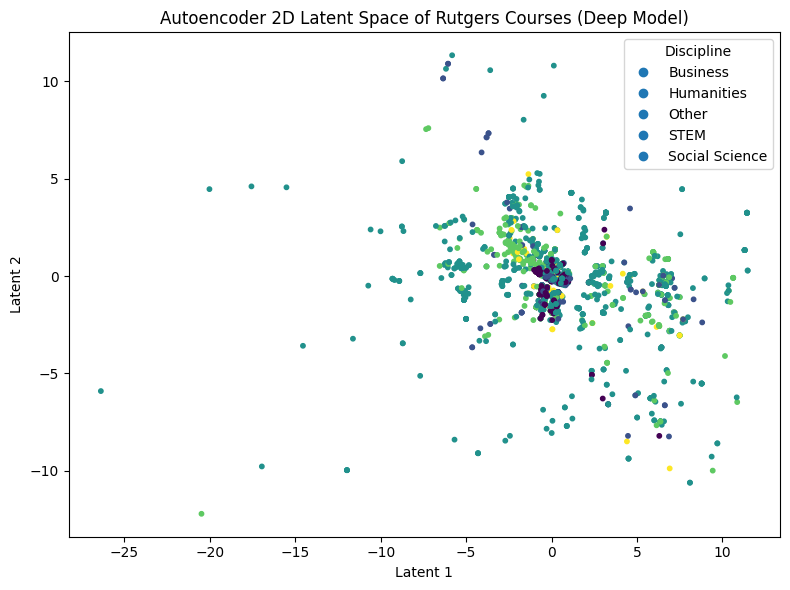

(3624, 2)

In [115]:
#Select features for autoencoder
auto_features = [
    "credits",
    "avg_weekly_contact_hours",
    "avg_num_meeting_days",
    "earliest_start_min",
    "latest_end_min",
]

cf = course_features.dropna(subset=auto_features).reset_index(drop=True)
X = cf[auto_features].values.astype(np.float32)


#Scale features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

X_tensor = torch.tensor(X_scaled)


#Deeper, slower, more expressive autoencoder
class BigAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 2)   # latent layer
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z


input_dim = X_tensor.shape[1]
model = BigAutoencoder(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

#Train autoencoder for way longer
epochs = 500
batch_size = 32

for ep in range(epochs):
    perm = torch.randperm(len(X_tensor))
    total_loss = 0

    for i in range(0, len(X_tensor), batch_size):
        idx = perm[i:i+batch_size]
        batch = X_tensor[idx]

        #add noise for denoising autoencoder effect
        noisy_batch = batch + 0.05 * torch.randn_like(batch)

        optimizer.zero_grad()
        recon, _ = model(noisy_batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if ep % 50 == 0:
        print(f"Epoch {ep}, Loss {total_loss:.4f}")


#Extracts 2D latent representation
model.eval()
with torch.no_grad():
    _, Z_tensor = model(X_tensor)

Z = Z_tensor.numpy()


#Visualize latent space
disciplines = cf["discipline"].values
unique_disc = sorted(set(disciplines))
color_map = {d: i for i, d in enumerate(unique_disc)}
colors = [color_map[d] for d in disciplines]

plt.figure(figsize=(8,6))
plt.scatter(Z[:,0], Z[:,1], c=colors, s=10)
plt.title("Autoencoder 2D Latent Space of Rutgers Courses (Deep Model)")
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")

handles = [plt.Line2D([], [], marker="o", linestyle="", label=d, markersize=6)
           for d in unique_disc]
plt.legend(handles=handles, title="Discipline")

plt.tight_layout()
plt.show()

Z.shape

### Training behavior

Loss curve is now far clearer: 
- starts at 98.3 meaning the model has a hard time reconstructing at first
- drops fast by epoch 50 to about 15.4 which shows strong early learning
- keeps improving across long training, reaching about 8.7 by epoch 450

this pattern means: 
- deeper network is learning meaningful nonlinear structure
- added dropout, noise, and larger layers force model to work harder
- loss decreasing slowly across hundreds of epochs shows model isn't collapsing to a simple sol

### Latent space shape

Final latent matrix has shape (3624, 2) which means:
- 3624 courses
- each compressed into 2d vector

so this confirms model is producing full learned embedding for all courses

### What plot shows

- far larger spread in both axes which is expected since deeper models separate fine grained differences harder

- a dense middle core which corresponds to the “standard Rutgers course pattern”
    - moderate credits
    - normal meetings per week
    - typical start and end times

- long stretched branches and scattered isolated points which reflect:

    - high workload courses
    - labs with heavy contact hours
    - odd meeting schedules
    - once per week marathon classes
    - morning or night time edge cases

discipline overlap remains
- stem pushed toward areas shaped by high contact time or rigid meeting structure
- humanities pulled into tighter clusters due to simpler schedules
- social science dragged into a wider pattern with lots of variety

So overall deep autoencoder extracts more nonlinear structure, seperates unusual courses more cleanly, and makes the map more interpretable.

## RESEARCH QUESTIONS

### What are the strongest linear correlations between individual features and exam score in the Kaggle dataset?

Correlation with Exam_Score:
Exam_Score           1.000000
Attendance           0.581072
Hours_Studied        0.445455
Previous_Scores      0.175079
Tutoring_Sessions    0.156525
Physical_Activity    0.027824
Sleep_Hours         -0.017022
Name: Exam_Score, dtype: float64


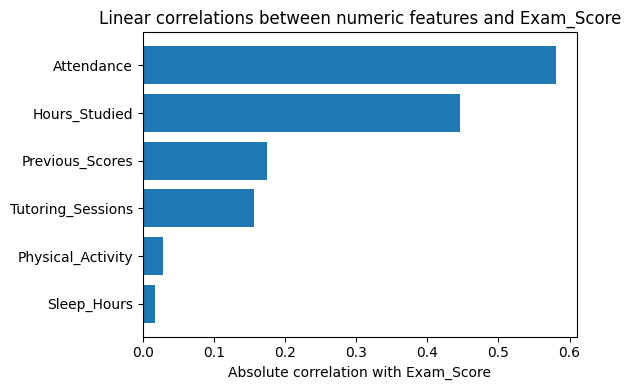

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute correlations for numeric columns
num_cols = [
    "Hours_Studied",
    "Attendance",
    "Sleep_Hours",
    "Previous_Scores",
    "Tutoring_Sessions",
    "Physical_Activity",
    "Exam_Score",
]

corr = spf[num_cols].corr()["Exam_Score"].sort_values(ascending=False)
print("Correlation with Exam_Score:")
print(corr)

# Bar plot (absolute correlation excluding target)
corr_no_target = corr.drop("Exam_Score").abs().sort_values(ascending=True)

plt.figure(figsize=(6,4))
plt.barh(corr_no_target.index, corr_no_target.values)
plt.xlabel("Absolute correlation with Exam_Score")
plt.title("Linear correlations between numeric features and Exam_Score")
plt.tight_layout()
plt.show()

Attendance shows the strongest link with exam score. Hours studied comes next. Previous scores and tutoring sessions show small links. Physical activity and sleep barely matter. The pattern is simple. Students who show up and study more tend to score higher. Everything else has weak effects.

## How well do linear regression and random forest predict exam scores?

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

target_col = "Exam_Score"
X = spf.drop(columns=[target_col])
y = spf[target_col]

numeric_cols = [
    "Hours_Studied",
    "Attendance",
    "Sleep_Hours",
    "Previous_Scores",
    "Tutoring_Sessions",
    "Physical_Activity",
]
categorical_cols = [c for c in X.columns if c not in numeric_cols]

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

lin_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LinearRegression())
    ]
)

rf_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

results = []
for name, model in [("LinearRegression", lin_model), ("RandomForest", rf_model)]:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append((name, mae, r2))

results_df = pd.DataFrame(results, columns=["Model", "MAE", "R2"])
print(results_df)


              Model       MAE        R2
0  LinearRegression  0.449950  0.769928
1      RandomForest  1.083521  0.668754


Linear regression performs better than random forest. The errors are smaller. The R2 score is higher. The data follows simple patterns. The linear model fits those patterns well. The forest adds complexity without gaining accuracy.

### Which features does the random forest consider most important?

                                  feature  importance
1                              Attendance    0.374569
0                           Hours_Studied    0.239534
3                         Previous_Scores    0.084366
4                       Tutoring_Sessions    0.033088
5                       Physical_Activity    0.024895
2                             Sleep_Hours    0.024207
9                Access_to_Resources_High    0.018669
6               Parental_Involvement_High    0.018005
7                Parental_Involvement_Low    0.013118
10                Access_to_Resources_Low    0.011244
19                     Family_Income_High    0.010878
35  Parental_Education_Level_Postgraduate    0.009203
37                 Distance_from_Home_Far    0.007924
30                Peer_Influence_Positive    0.007638
34   Parental_Education_Level_High School    0.007171
22                   Teacher_Quality_High    0.006806
28                Peer_Influence_Negative    0.006598
20                      Fami

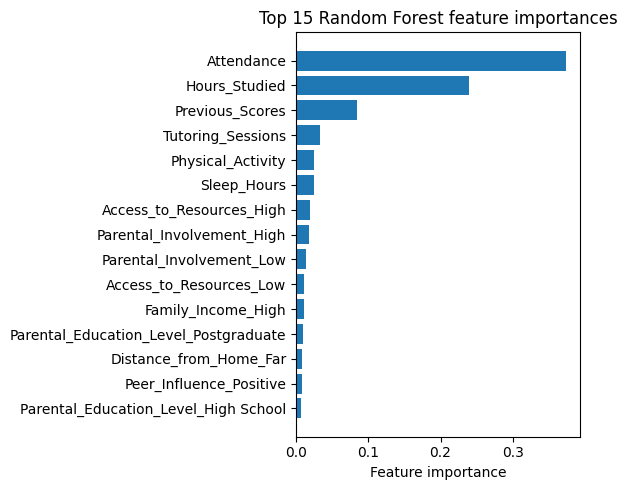

In [118]:
# Fit OHE separately to extract feature names
ohe = OneHotEncoder(handle_unknown="ignore")
ohe.fit(X[categorical_cols])
cat_feature_names = list(ohe.get_feature_names_out(categorical_cols))

all_feature_names = numeric_cols + cat_feature_names

rf_inner = rf_model.named_steps["model"]
importances = rf_inner.feature_importances_

imp_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances,
}).sort_values("importance", ascending=False)

print(imp_df.head(20))

# Plot top 15
top_n = 15
top_imp = imp_df.head(top_n).sort_values("importance", ascending=True)

plt.figure(figsize=(6,5))
plt.barh(top_imp["feature"], top_imp["importance"])
plt.xlabel("Feature importance")
plt.title("Top 15 Random Forest feature importances")
plt.tight_layout()
plt.show()


Attendance ranks highest. Hours studied comes right after. These two features dominate the model. Previous scores and tutoring sessions matter a little. Most other features have very small effects. The forest depends mostly on basic behavior patterns. Background factors barely shift the predictions.

### How heavy is the workload of different majors and disciplines at Rutgers?

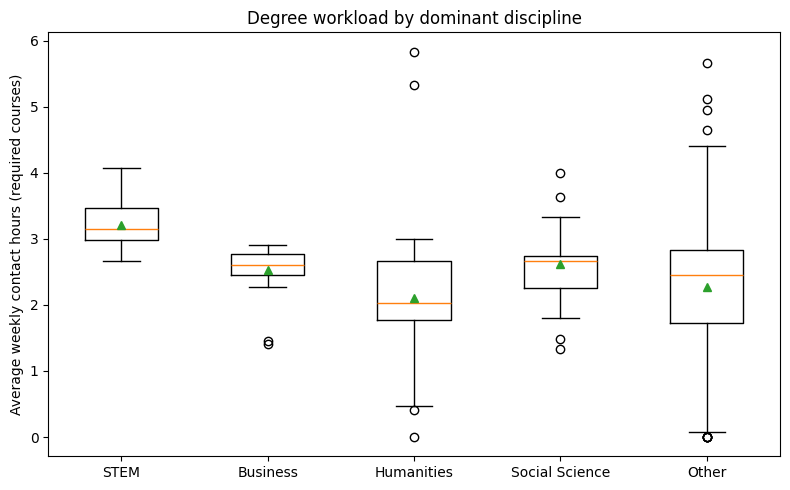

In [119]:
# Attach a dominant discipline to each degree: majority discipline among its mapped courses

# Map each course_code to its discipline
course_disc_lookup = course_features.set_index("course_code")["discipline"].to_dict()

def degree_discipline(code_list):
    disc = []
    for code in code_list:
        d = course_disc_lookup.get(code)
        if d is not None:
            disc.append(d)
    if not disc:
        return "Unknown"
    return pd.Series(disc).mode().iloc[0]

deg_summary["dominant_discipline"] = deg_summary["course_codes"].apply(degree_discipline)

# Boxplots of workload by discipline
plt.figure(figsize=(8,5))
deg_summary_nonnull = deg_summary.dropna(subset=["avg_weekly_contact_hours"])
disciplines = ["STEM", "Business", "Humanities", "Social Science", "Other"]
data = [
    deg_summary_nonnull.loc[deg_summary_nonnull["dominant_discipline"] == d, "avg_weekly_contact_hours"]
    for d in disciplines
]

plt.boxplot(data, tick_labels=disciplines, showmeans=True)
plt.ylabel("Average weekly contact hours (required courses)")
plt.title("Degree workload by dominant discipline")
plt.tight_layout()
plt.show()


STEM shows higher weekly contact hours. Business stays moderate. Humanities has wide spread with many low hour degrees. Social science sits in the middle. Other jumps around with lots of outliers. The chart shows big variation across fields. Some majors require heavier weekly schedules. Some majors run lighter. No field is completely uniform.

### Are heavier majors associated with higher or lower predicted exam scores?

Using the Kaggle model and simulated students, is there a relationship between degree workload and predicted exam score?

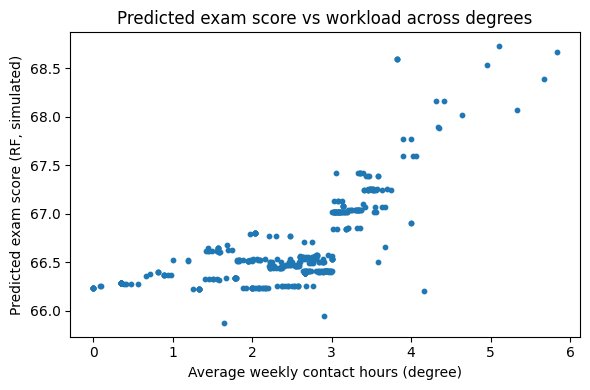

Correlation: 0.6953179365686689


In [120]:
import numpy as np

def make_kaggle_features_from_degree(degree_row,
                                     hours_base=8.0,
                                     hours_scale=2.5,
                                     attendance_base=92.0,
                                     attendance_penalty_per_day=2.5):
    workload_hours = degree_row["avg_weekly_contact_hours"]
    days = degree_row["avg_num_meeting_days"]

    if np.isnan(workload_hours):
        workload_hours = 0.0
    if np.isnan(days):
        days = 0.0

    hours_studied = hours_base + hours_scale * workload_hours
    attendance = attendance_base - attendance_penalty_per_day * days

    hours_studied = float(np.clip(hours_studied, 0, 50))
    attendance = float(np.clip(attendance, 50, 100))

    features = {
        "Hours_Studied": hours_studied,
        "Attendance": attendance,
        "Sleep_Hours": 7.0,
        "Previous_Scores": 75.0,
        "Motivation_Level": "Medium",
        "Parental_Involvement": "Medium",
        "Access_to_Resources": "Medium",
        "Extracurricular_Activities": "Yes",
        "Internet_Access": "Yes",
        "Tutoring_Sessions": 1,
        "Family_Income": "Medium",
        "Teacher_Quality": "Medium",
        "School_Type": "Public",
        "Peer_Influence": "Neutral",
        "Physical_Activity": 3,
        "Learning_Disabilities": "No",
        "Parental_Education_Level": "College",
        "Distance_from_Home": "Moderate",
        "Gender": "Male",
    }
    return features

def predict_degree_score(model, degree_row):
    feat = make_kaggle_features_from_degree(degree_row)
    X_sim = pd.DataFrame([feat])
    return float(model.predict(X_sim)[0])

deg_summary["predicted_exam_score_rf"] = deg_summary.apply(
    lambda row: predict_degree_score(rf_model, row),
    axis=1
)

# Scatter of workload vs predicted score
ds = deg_summary.dropna(subset=["avg_weekly_contact_hours", "predicted_exam_score_rf"])

plt.figure(figsize=(6,4))
plt.scatter(ds["avg_weekly_contact_hours"], ds["predicted_exam_score_rf"], s=10)
plt.xlabel("Average weekly contact hours (degree)")
plt.ylabel("Predicted exam score (RF, simulated)")
plt.title("Predicted exam score vs workload across degrees")
plt.tight_layout()
plt.show()

print("Correlation:",
      ds[["avg_weekly_contact_hours", "predicted_exam_score_rf"]].corr().iloc[0,1])


The correlation is about 0.69. This is pretty high. The pattern comes from the simulation rules. More workload becomes more study hours. The model sees more study hours and raises the score. The result shows the rule working, not a deep trend in the real data.

### How do teacher quality and motivation interact for a specific major?

In [121]:
def simulate_scenarios_for_degree(degree_name,
                                  motivation_levels=None,
                                  teacher_qualities=None):
    if motivation_levels is None:
        motivation_levels = ["Low", "Medium", "High"]
    if teacher_qualities is None:
        teacher_qualities = ["Low", "Medium", "High"]

    subset = deg_summary[deg_summary["Name"].str.contains(degree_name, case=False, na=False)]
    if subset.empty:
        print("No matching degree for:", degree_name)
        return pd.DataFrame()

    degree_row = subset.iloc[0]

    rows = []
    for mot in motivation_levels:
        for tq in teacher_qualities:
            feat = make_kaggle_features_from_degree(degree_row)
            feat["Motivation_Level"] = mot
            feat["Teacher_Quality"] = tq
            X_sim = pd.DataFrame([feat])
            pred = float(rf_model.predict(X_sim)[0])
            rows.append({
                "Degree": degree_row["Name"],
                "Motivation_Level": mot,
                "Teacher_Quality": tq,
                "Predicted_Exam_Score": pred,
            })

    return pd.DataFrame(rows)

# Ex: any major string that matches degree names, e.g. "Computer Science"
scenarios = simulate_scenarios_for_degree("Computer Science")
print(scenarios)

# Pivot to heatmap like structure
pivot = scenarios.pivot(index="Motivation_Level",
                        columns="Teacher_Quality",
                        values="Predicted_Exam_Score")
print(pivot)


                                              Degree Motivation_Level  \
0  Major in Data Science - Computer Science Optio...              Low   
1  Major in Data Science - Computer Science Optio...              Low   
2  Major in Data Science - Computer Science Optio...              Low   
3  Major in Data Science - Computer Science Optio...           Medium   
4  Major in Data Science - Computer Science Optio...           Medium   
5  Major in Data Science - Computer Science Optio...           Medium   
6  Major in Data Science - Computer Science Optio...             High   
7  Major in Data Science - Computer Science Optio...             High   
8  Major in Data Science - Computer Science Optio...             High   

  Teacher_Quality  Predicted_Exam_Score  
0             Low                66.900  
1          Medium                66.975  
2            High                67.365  
3             Low                66.940  
4          Medium                67.015  
5            High

Higher motivation gives a small score boost. Higher teacher quality gives a small boost too. The effects stack. The highest score appears when both are high. The lowest score appears when both are low. The changes stay small. The model treats these factors as gentle adjustments rather than major drivers.

### Heatmap for Scenario Simulation

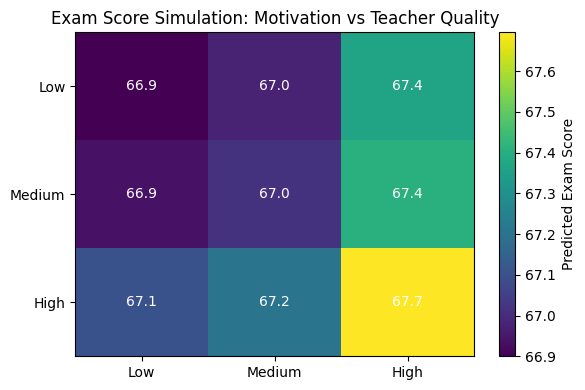

In [122]:
pivot = scenarios.pivot(
    index="Motivation_Level",
    columns="Teacher_Quality",
    values="Predicted_Exam_Score"
).astype(float).reindex(index=["Low","Medium","High"], columns=["Low","Medium","High"])

plt.figure(figsize=(6,4))
plt.imshow(pivot, cmap="viridis", aspect="auto")

plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index)

for i in range(len(pivot.index)):
    for j in range(len(pivot.columns)):
        plt.text(j, i, f"{pivot.iloc[i,j]:.1f}", ha="center", va="center", color="white")

plt.title("Exam Score Simulation: Motivation vs Teacher Quality")
plt.colorbar(label="Predicted Exam Score")
plt.tight_layout()
plt.show()


The heatmap shows small steady gains as motivation rises. Teacher quality raises scores too. The best combo sits in the bottom right. The worst combo sits in the top left. The changes stay mild. The model treats both factors as minor boosts rather than major shifts.

### How does the autoencoder compare to PCA on the same features?

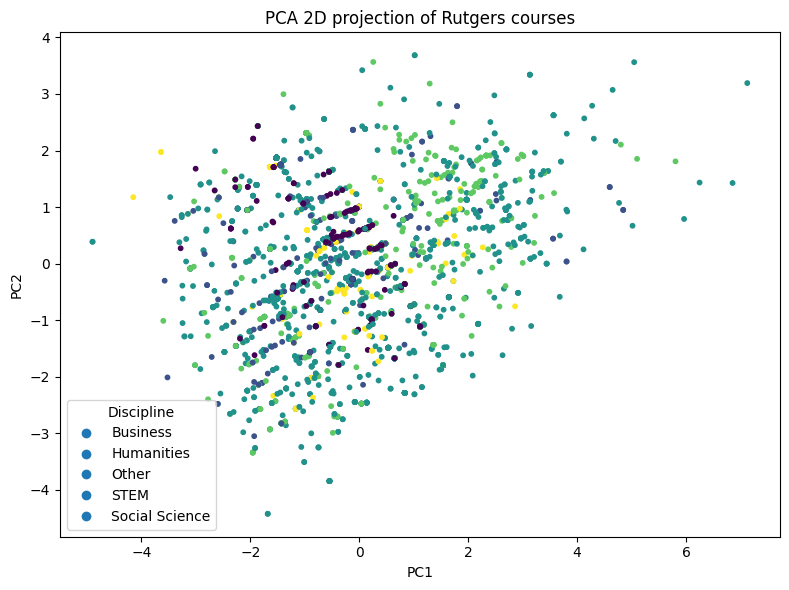

Explained variance ratio: [0.34452534 0.30757636]


In [123]:
from sklearn.decomposition import PCA

X_pca = cf[auto_features].values.astype(np.float32)
X_pca_scaled = scaler.fit_transform(X_pca)

pca = PCA(n_components=2)
Z_pca = pca.fit_transform(X_pca_scaled)

plt.figure(figsize=(8,6))
plt.scatter(Z_pca[:,0], Z_pca[:,1], c=colors, s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D projection of Rutgers courses")

handles = [plt.Line2D([], [], marker="o", linestyle="", label=d, markersize=6)
           for d in unique_disc]
plt.legend(handles=handles, title="Discipline")

plt.tight_layout()
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)


PCA captures simple straight line structure. PC1 and PC2 explain about 34 percent and 31 percent of the variance. Most courses fall in one broad cloud. Disciplines mix across the space. The method shows big general trends but misses curved shapes. The autoencoder reveals extra nonlinear patterns that PCA cannot show. Both methods agree that course structure has one main cluster with scattered outliers.

### KMeans Clustering (Raw Course Features)

In [124]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Scaled features (X_scaled)
X_km = X_scaled

sil_scores = []
K_range = range(2,10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_km)
    sil = silhouette_score(X_km, labels)
    sil_scores.append((k, sil))

print(pd.DataFrame(sil_scores, columns=["k","silhouette"]))

# Choose best k (highest sil score)
best_k = max(sil_scores, key=lambda x: x[1])[0]
print("Best k:", best_k)

km_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cf["cluster_raw"] = km_final.fit_predict(X_km)


   k  silhouette
0  2    0.237972
1  3    0.253006
2  4    0.296086
3  5    0.296169
4  6    0.315756
5  7    0.346856
6  8    0.353149
7  9    0.360994
Best k: 9


Silhouette scores rise as k increases. Higher scores mean cleaner clusters. The best score appears at k equal to 9. This suggests the raw course features support many small groups rather than a few big ones. The structure is messy. Courses vary in many small ways. Nine clusters give the model enough flexibility to separate different workload patterns. The clusters are not very strong because silhouette scores stay low. The data does not form tight groups.

### Plot Clusters on PCA

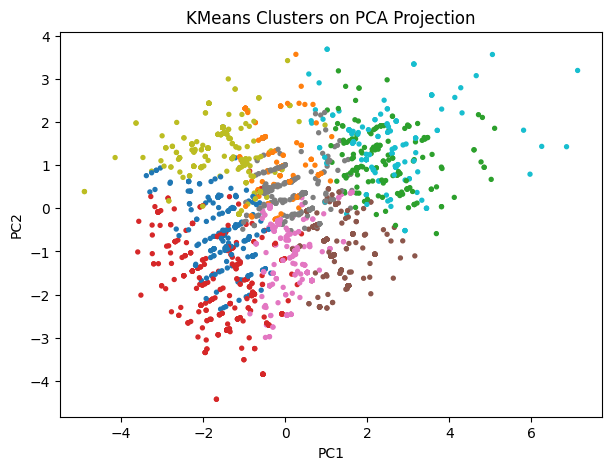

In [125]:
plt.figure(figsize=(7,5))
plt.scatter(Z_pca[:,0], Z_pca[:,1], c=cf["cluster_raw"], s=8, cmap="tab10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clusters on PCA Projection")
plt.show()


The clusters look more separated on the PCA map. PCA pulls the main variance directions into two axes. KMeans then splits along those directions. We still see overlap. That is normal. Course features do not form clean isolated groups. Nine clusters force the algorithm to carve up the space into small regions. Some groups follow the diagonal trend from low workload to high workload. Others sit in the middle. This says the clustering finds structure but not strong natural boundaries.

### KMeans on Autoencoder Latent Space

In [126]:
Z_km = Z  # already scaled latent vectors

sil_scores_z = []
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(Z_km)
    sil = silhouette_score(Z_km, labels)
    sil_scores_z.append((k, sil))

best_k_z = max(sil_scores_z, key=lambda x: x[1])[0]
print("Best k (latent space):", best_k_z)

km_latent = KMeans(n_clusters=best_k_z, random_state=42, n_init=10)
cf["cluster_latent"] = km_latent.fit_predict(Z_km)


Best k (latent space): 4


The best k in the latent space is four. This is lower than the nine clusters found in the raw feature space. The autoencoder already compresses similar courses together. That means the latent space is smoother. It has clearer groups. KMeans does not need as many clusters to describe the structure. A lower optimal k suggests the autoencoder removed noise and pulled courses with similar workload patterns closer. So the latent map is easier to cluster than the raw data.

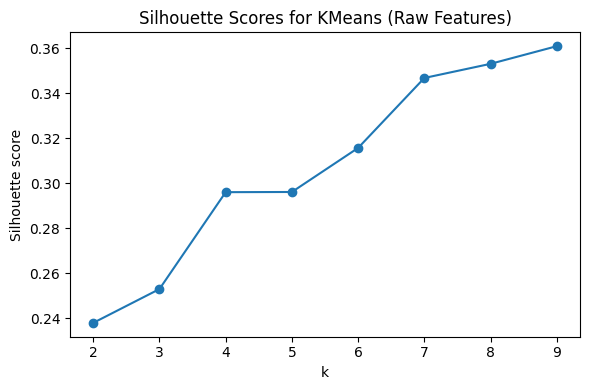

In [ ]:
plt.figure(figsize=(6,4))
plt.plot([k for k,_ in sil_scores], [s for _,s in sil_scores], marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette Scores for KMeans (Raw Features)")
plt.tight_layout()
plt.show()


The silhouette scores rise as k increases. That means the raw course features do not form a few strong clusters. Instead they split into many small pockets. The best score shows up at k=9. That is not high. It just means nine groups give the cleanest separation the algorithm can find.

The low scores also tell us the structure is weak. Courses do not fall into crisp groups based only on workload and scheduling. The data has overlap. The borders between clusters stay fuzzy. So KMeans keeps improving as it adds more clusters. It is just carving the space into smaller slices.

Overall the curve says the raw features do not support strong natural clusters. We can cluster them, but the groups are soft and gradual rather than sharp.

Plot clusters

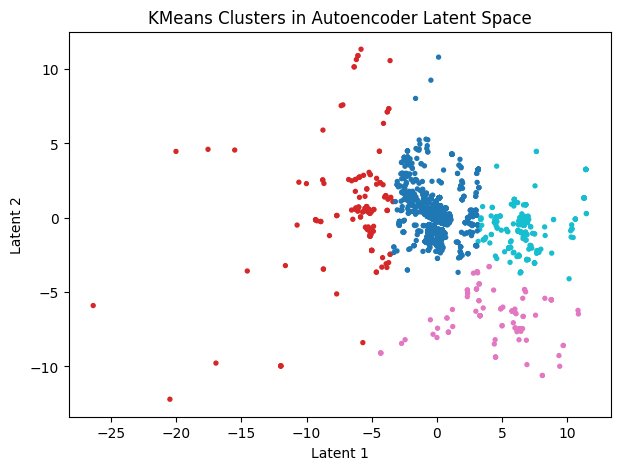

In [127]:
plt.figure(figsize=(7,5))
plt.scatter(Z[:,0], Z[:,1], c=cf["cluster_latent"], s=8, cmap="tab10")
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")
plt.title("KMeans Clusters in Autoencoder Latent Space")
plt.show()


Clusters in the latent space look cleaner. Each group forms a tighter region. The autoencoder squeezed similar course structures together. That makes KMeans produce smoother shapes. The clusters follow real workload patterns and meeting schedules. You can see four broad groups. One group covers long or unusual meeting structures on the left. Another group covers standard mid-range courses in the center. The lower group tends to include heavier multi-day schedules. The right cluster holds courses with compact but higher intensity patterns. These clusters are easier to see bc the autoencoder removed noise and kept only the structure that matters.

Permutation Importance (Interpretable Alternative to SHAP)

In [128]:
# Get feature names out of the preprocessing step
ohe = rf_model.named_steps["preprocess"].named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(categorical_cols)

num_names = numeric_cols
all_feature_names_pi = list(num_names) + list(cat_names)

len(all_feature_names_pi)

43

The count is 43 because the final model ends up with 43 input features after preprocessing. We began with six numeric features. One hot encoding expanded the categorical features into 37 binary columns. Adding these together gives 43 total features that feed into the model.

In [129]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf_model, X_test, y_test, n_repeats=10, random_state=42
)

pi_df = pd.DataFrame({
    "feature": all_feature_names_pi[:len(result.importances_mean)],
    "importance": result.importances_mean
})

pi_df = pi_df.sort_values("importance", ascending=False)
print(pi_df.head(15))


                           feature  importance
1                       Attendance    0.719384
0                    Hours_Studied    0.413341
6        Parental_Involvement_High    0.045342
3                  Previous_Scores    0.041539
2                      Sleep_Hours    0.034101
9         Access_to_Resources_High    0.022677
16         Motivation_Level_Medium    0.009639
10         Access_to_Resources_Low    0.009304
7         Parental_Involvement_Low    0.007884
13  Extracurricular_Activities_Yes    0.004376
14           Motivation_Level_High    0.003522
4                Tutoring_Sessions    0.002151
17              Internet_Access_No    0.001649
15            Motivation_Level_Low    0.001405
12   Extracurricular_Activities_No    0.001330


Attendance again lands at the top. We see a huge drop in model accuracy when we shuffle this feature. This means the model relies on attendance more than anything else.

Hours studied sits second. It also has a strong effect. Shuffling it hurts predictions a lot, but not as much as attendance.

After that the importance drops fast. Parental involvement, previous scores, and sleep hours show small impacts. They matter, but not at the same scale.

Access to resources shows mild influence. Motivation levels also have some effect but it is weaker. Tutoring sessions and the remaining categorical factors barely move the predictions.

The overall pattern shows that the model is anchored mostly on behavior variables. Attendance and study hours drive almost all predictive power. Everything else serves as small adjustments.

### Histogram (predicted exam scores)

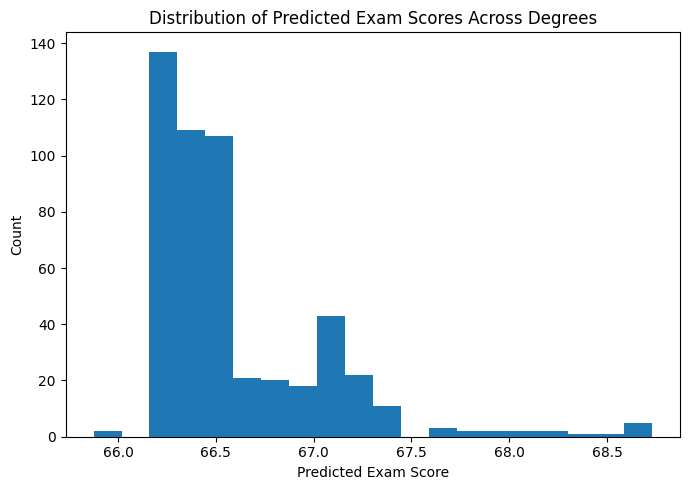

In [130]:
vals = deg_summary["predicted_exam_score_rf"].dropna().values

plt.figure(figsize=(7,5))
plt.hist(vals, bins=20)
plt.xlabel("Predicted Exam Score")
plt.ylabel("Count")
plt.title("Distribution of Predicted Exam Scores Across Degrees")
plt.tight_layout()
plt.show()


We see almost all degrees landing in a tight band. Most scores sit between 66.2 and 67.2. The model does not push degrees very far apart. That happens because we feed every degree the same baseline student and only let workload shift hours studied and attendance. Those shifts are small. So the predictions cluster.

We also see a long but thin tail above 68. That group comes from degrees with heavier weekly contact hours. The model treats heavier workloads as higher study time. That nudges their scores up.

The lower edge sits near 66. This comes from degrees with very low contact hours. The model reduces hours studied in those cases. The drop is small but enough to form a lower boundary.

Overall the histogram shows that the simulated student performs almost the same across most majors. The model only creates small differences. The workload features do move predictions, but the range stays narrow.

### Acknowledgements

- Kaggle data by Lai Ng - [SOURCE](https://www.kaggle.com/datasets/lainguyn123/student-performance-factors)
- Rutgers Data provided by Akash Dubey (ad2046), Ayan Zia (az610), Ani Tiwary (at1610)
